In [118]:
import warnings
import json

import pandas as pd
import numpy as np

from jre_utils.datapath import (
    factor_data_paths,
    get_derived_csv_path,
    get_derived_lpa_path,
    get_derived_plps_path,
    DATA_DIRECTORY_PATH
)
from jre_utils.config import asset_types
from jre_utils.visualize import plot_time_series

from jp_prefecture.jp_cities import jp_cities as jp

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [119]:
asset_type = "building"

metrics = {
    "weighted_mean": "unit_price_wmean",
    "weighted_median": "unit_price_wmedian",
    "mean": "unit_price_mean",
    "median": "unit_price_median",
}

dataset_paths = {
    "main": get_derived_csv_path(asset_type),
    "lpa": get_derived_lpa_path(),
    "plps": get_derived_plps_path()
}

In [120]:
granularity_columns = ["area", "area_code"]
group_by_columns = granularity_columns + ["year"]
display_columns = ["unit_price", "total_traded_area", "count"]

metric = metrics["weighted_median"]
metric_pct_chg = metric + "_pct_chg"

In [151]:
core_df_path = dataset_paths["main"]
population_path = factor_data_paths["processed"]["population"]["municipality"]
taxable_income_path = factor_data_paths["processed"]["taxable_income"]["municipality"]
new_dwellings_path = factor_data_paths["processed"]["new_dwellings"]["municipality"]

In [154]:
df = pd.read_csv(core_df_path)

population_df = pd.read_csv(population_path)
taxable_income_df = pd.read_csv(taxable_income_path)
new_dwellings_df = pd.read_csv(new_dwellings_path)

factors = ["population", "taxable_income", "new_dwellings"]

df = (
    df.merge(
        population_df[group_by_columns + ["population"]],
        on=group_by_columns,
        how="left",
    )
    .merge(
        taxable_income_df[group_by_columns + ["taxable_income"]],
        on=group_by_columns,
        how="left",
    )
    .merge(
        new_dwellings_df[group_by_columns + ["existing_dwellings"]],
        on=group_by_columns,
        how="left",
    )
)

df["area_code"] = df["area_code"].astype(str)

In [136]:
n = 20
random_area_codes = np.random.choice(df["area_code"].unique(), n)
random_area_codes

array(['20448', '5203', '47329', '6365', '29344', '42211', '11209',
       '15216', '14363', '2408', '13123', '1303', '36202', '43428',
       '4404', '31302', '21204', '12226', '3201', '1585'], dtype=object)

In [155]:
# area_code = "5214" # Akita-ken Nikaho-shi
area_code = "5203"
area_df = df[df["area_code"] == area_code].sort_values(by="year", ascending=True)
area_df

,year,area_code,area,unit_price_wmean,unit_price_wmedian,unit_price_mean,unit_price_median,total_traded_area,count,population,taxable_income,taxpayer_count,taxable_income_per_taxpayer,taxable_income_growth,taxable_income_per_taxpayer_growth,new_dwellings,existing_dwellings,new_dwellings_ratio
20119,2007,5203,Akita-ken Yokote-shi,24422.202002,26553.352559,18320.432517,16923.076923,5495.0,9.0,91157.0,93447050.0,37119.0,2517.499124,-0.005792,-0.004105,591.0,31663.0,0.018665
20094,2008,5203,Akita-ken Yokote-shi,25469.824042,16675.000000,33217.919925,20000.000000,30405.0,60.0,90874.0,93508537.0,37184.0,2514.751963,0.000658,-0.001091,460.0,32254.0,0.014262
20071,2009,5203,Akita-ken Yokote-shi,25225.742080,15278.392494,33879.632363,18340.909091,20045.0,60.0,90213.0,90642450.0,36844.0,2460.168548,-0.030651,-0.021705,311.0,32714.0,0.009507
20047,2010,5203,Akita-ken Yokote-shi,23421.197794,11181.159420,40202.041536,24523.076923,25380.0,52.0,89765.0,84090865.0,34440.0,2441.662747,-0.072279,-0.007522,322.0,33025.0,0.009750
20024,2011,5203,Akita-ken Yokote-shi,49058.565154,19611.992945,53797.222243,22500.000000,20490.0,48.0,89539.0,83150738.0,34041.0,2442.664375,-0.011180,0.000410,195.0,33347.0,0.005848
20003,2012,5203,Akita-ken Yokote-shi,24430.961839,14812.526183,30707.149023,24324.324324,41535.0,71.0,89237.0,85052327.0,34922.0,2435.494158,0.022869,-0.002935,283.0,33542.0,0.008437
19981,2013,5203,Akita-ken Yokote-shi,21822.428592,7500.000000,46931.506420,17419.354839,35535.0,67.0,88769.0,86102307.0,35240.0,2443.311776,0.012345,0.003210,324.0,33825.0,0.009579
19958,2014,5203,Akita-ken Yokote-shi,21811.480023,14266.666667,41847.260929,19492.939666,35540.0,78.0,88148.0,85059667.0,34736.0,2448.746747,-0.012109,0.002224,333.0,34149.0,0.009751
19936,2015,5203,Akita-ken Yokote-shi,23977.854900,12500.000000,36734.266454,20483.682984,30255.0,66.0,87697.0,84314410.0,33765.0,2497.094921,-0.008762,0.019744,303.0,34482.0,0.008787
19912,2016,5203,Akita-ken Yokote-shi,24411.752620,16311.859295,35336.587613,18461.538462,24335.0,55.0,87195.0,86365071.0,34787.0,2482.682353,0.024322,-0.005772,279.0,34785.0,0.008021


In [147]:
# ma3
metric = metrics["weighted_median"]
temporal_smoothed_metric = f"{metric}_smoothed_temporal"
area_df[temporal_smoothed_metric] = area_df[metric].rolling(window=3).mean()


plot_time_series(
    area_df,
    metric,
    group_by_columns,
    granularity_columns,
    f"Unit Price over time",
    # visible="legendonly",
    width=1000,
    height=400,
    showlegend=False
)

plot_time_series(
    area_df,
    temporal_smoothed_metric,
    group_by_columns,
    granularity_columns,
    f"Smoothed Unit Price over time",
    # visible="legendonly",
    width=1000,
    height=400,
    showlegend=False
)

for factor in factors:
    plot_time_series(
    area_df,
    factor,
    group_by_columns,
    granularity_columns,
    f"{factor} over time",
    # visible="legendonly",
    width=1000,
    height=400,
    showlegend=False
)

# Other Candidates

In [149]:
# ma3
metric = metrics["weighted_median"]
temporal_smoothed_metric = f"{metric}_smoothed_temporal"
area_df[temporal_smoothed_metric] = area_df[metric].rolling(window=2).mean()


plot_time_series(
    area_df,
    metric,
    group_by_columns,
    granularity_columns,
    f"Unit Price over time",
    # visible="legendonly",
    width=1000,
    height=400,
    showlegend=False
)

plot_time_series(
    area_df,
    temporal_smoothed_metric,
    group_by_columns,
    granularity_columns,
    f"Unit Price over time",
    # visible="legendonly",
    width=1000,
    height=400,
    showlegend=False
)

In [140]:
# Weighted moving average
metric = metrics["weighted_median"]
temporal_smoothed_metric = f"{metric}_smoothed_temporal"

weights = np.array([1, 1, 1]) # [year - 2, year - 1, year]
weights_normalized = weights / np.sum(weights)
area_df[temporal_smoothed_metric] = area_df[metric].rolling(window=3).apply(lambda x: np.dot(x, weights_normalized))

plot_time_series(
    area_df,
    metric,
    group_by_columns,
    granularity_columns,
    f"Unit Price over time",
    # visible="legendonly",
    width=1000,
    height=400,
    showlegend=False
)

plot_time_series(
    area_df,
    temporal_smoothed_metric,
    group_by_columns,
    granularity_columns,
    f"Unit Price over time",
    # visible="legendonly",
    width=1000,
    height=400,
    showlegend=False
)

In [141]:
# Double Smoothing
metric = metrics["weighted_median"]
temporal_smoothed_metric_tmp = f"{metric}_smoothed_temporal_tmp"
temporal_smoothed_metric = f"{metric}_smoothed_temporal"
area_df[temporal_smoothed_metric_tmp] = area_df[metric].rolling(window=2).mean()
area_df[temporal_smoothed_metric] = area_df[temporal_smoothed_metric_tmp].rolling(window=2).mean()


plot_time_series(
    area_df,
    metric,
    group_by_columns,
    granularity_columns,
    f"Unit Price over time",
    # visible="legendonly",
    width=1000,
    height=400,
    showlegend=False
)

plot_time_series(
    area_df,
    temporal_smoothed_metric,
    group_by_columns,
    granularity_columns,
    f"Unit Price over time",
    # visible="legendonly",
    width=1000,
    height=400,
    showlegend=False
)

In [142]:
metric = metrics["weighted_median"]
temporal_smoothed_metric = f"{metric}_smoothed_temporal"
area_df[temporal_smoothed_metric] = area_df[metric].ewm(alpha=0.05).mean()

plot_time_series(
    area_df,
    metric,
    group_by_columns,
    granularity_columns,
    f"Unit Price over time",
    # visible="legendonly",
    width=1000,
    height=400,
    showlegend=False
)

plot_time_series(
    area_df,
    temporal_smoothed_metric,
    group_by_columns,
    granularity_columns,
    f"Unit Price over time",
    # visible="legendonly",
    width=1000,
    height=400,
    showlegend=False
)

# Experiments

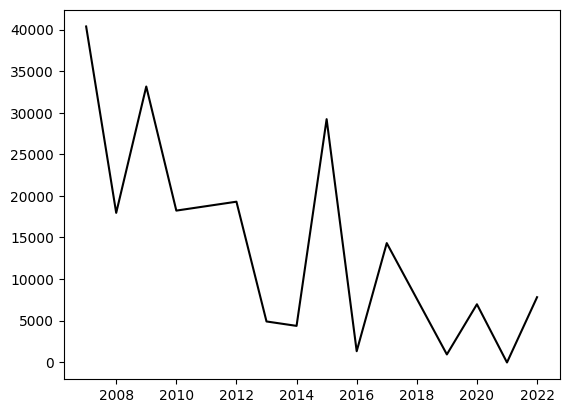

In [143]:
import matplotlib.pyplot as plt

# Fourier Transform
metric = metrics["weighted_median"]
temporal_smoothed_metric = f"{metric}_smoothed_temporal"

n = len(area_df)
fhat = np.fft.fft(area_df[metric], n)
PSD = fhat * np.conj(fhat) / n
freq = (1 / (n)) * np.arange(n)
L = np.arange(1, np.floor(n / 2), dtype="int")

# plt.plot(freq[L], PSD[L], color="k", label="PSD")

indices = PSD > 1e8
PSDclean = PSD * indices
fhat = indices * fhat
ffilt = np.fft.ifft(fhat)

plt.plot(area_df["year"], ffilt, color="k", label="filtered")

# Verdict - Pretty bad

In [144]:
from scipy.ndimage import convolve
# Two sided smoothing. Convolutions

metric = metrics["weighted_median"]
temporal_smoothed_metric = f"{metric}_smoothed_temporal"

filter_coefficients = np.array([0.5, 0.5, 0.5])
smoothed_values = np.convolve(area_df[metric], filter_coefficients, 'valid')

pad_length = len(area_df[metric]) - len(smoothed_values)
padded_smoothed_values = np.pad(smoothed_values, (pad_length, 0), mode='constant', constant_values=np.nan)

area_df[temporal_smoothed_metric] = padded_smoothed_values

plot_time_series(
    area_df,
    metric,
    group_by_columns,
    granularity_columns,
    f"Unit Price over time",
    # visible="legendonly",
    width=1000,
    height=400,
    showlegend=False
)

plot_time_series(
    area_df,
    temporal_smoothed_metric,
    group_by_columns,
    granularity_columns,
    f"Unit Price over time",
    # visible="legendonly",
    width=1000,
    height=400,
    showlegend=False
)